# Introduction to Process Mining with PM4PY
Code is partially copied from this tutorial: https://medium.com/@c3_62722/process-mining-with-python-tutorial-a-healthcare-application-part-1-ae02027a050

In [2]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
fn = 'ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()


,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [4]:
print('{} has {} rows and {} columns.'.format(fn, events.shape[0], events.shape[1]))


ArtificialPatientTreatment.csv has 690 rows and 4 columns.


### How many events per case?

Text(0, 0.5, 'Number of patients')

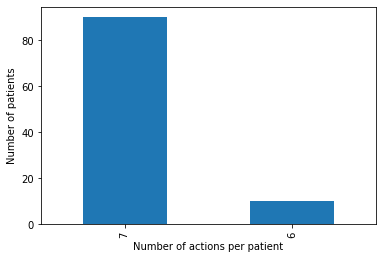

In [5]:
events['patient'].value_counts().value_counts().plot(kind='bar')
plt.xlabel('Number of actions per patient')
plt.ylabel('Number of patients')

In [6]:
events['patient'].value_counts().value_counts()

7    90
6    10
Name: patient, dtype: int64

### Action occurrences

Text(0, 0.5, 'number of occurrences')

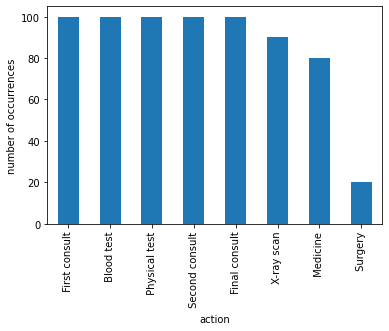

In [7]:
events['action'].value_counts().plot(kind='bar')
plt.xlabel('action')
plt.ylabel('number of occurrences')

# Process Mining

In [8]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.objects.conversion.process_tree import converter as pt_converter

import pm4py

In [9]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)


### Log Exploration

In [10]:
# start activities
log_start = pm4py.get_start_activities(log)
log_start

{' First consult': 100}

In [11]:
# end activities
end_activities = pm4py.get_end_activities(log)
end_activities

{' Final consult': 100}

In [12]:
# traces
variants = pm4py.get_variants_as_tuples(log)
print(len(variants))
variants

15


{(' First consult',
  ' Blood test',
  ' Physical test',
  ' Second consult',
  ' Surgery',
  ' Final consult'): [{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28')}]},
  {'attributes': {'concept:name': 'patient 95'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-05-15 09:15:08')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-05-26 10:19:34')}]}],
 (' First consult',
  ' Physical test',
  ' Blood test',
  ' X-ray scan',
  ' Second consult',
  ' Medicine',
  ' Final consult'): [{'attributes': {'concept:name': 'patient 1'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('201

In [13]:
# activities
activities = pm4py.get_event_attribute_values(log, "concept:name")
print(activities)

{' First consult': 100, ' Blood test': 100, ' Physical test': 100, ' Second consult': 100, ' Surgery': 20, ' Final consult': 100, ' X-ray scan': 90, ' Medicine': 80}


In [14]:
# resources
resources = pm4py.get_event_attribute_values(log, "org:resource")
print(resources)

{' Dr. Anna': 158, ' Lab': 100, ' Nurse Jesse': 57, ' Dr. Charlie': 5, ' Dr. Ben': 50, ' Team 1': 40, ' Pharmacy': 80, ' Team 2': 50, ' Nurse Corey': 43, ' Dr. Bob': 92, ' Dr. Rudy': 7, ' Dr. Alex': 5, ' Dr. Quinn': 3}


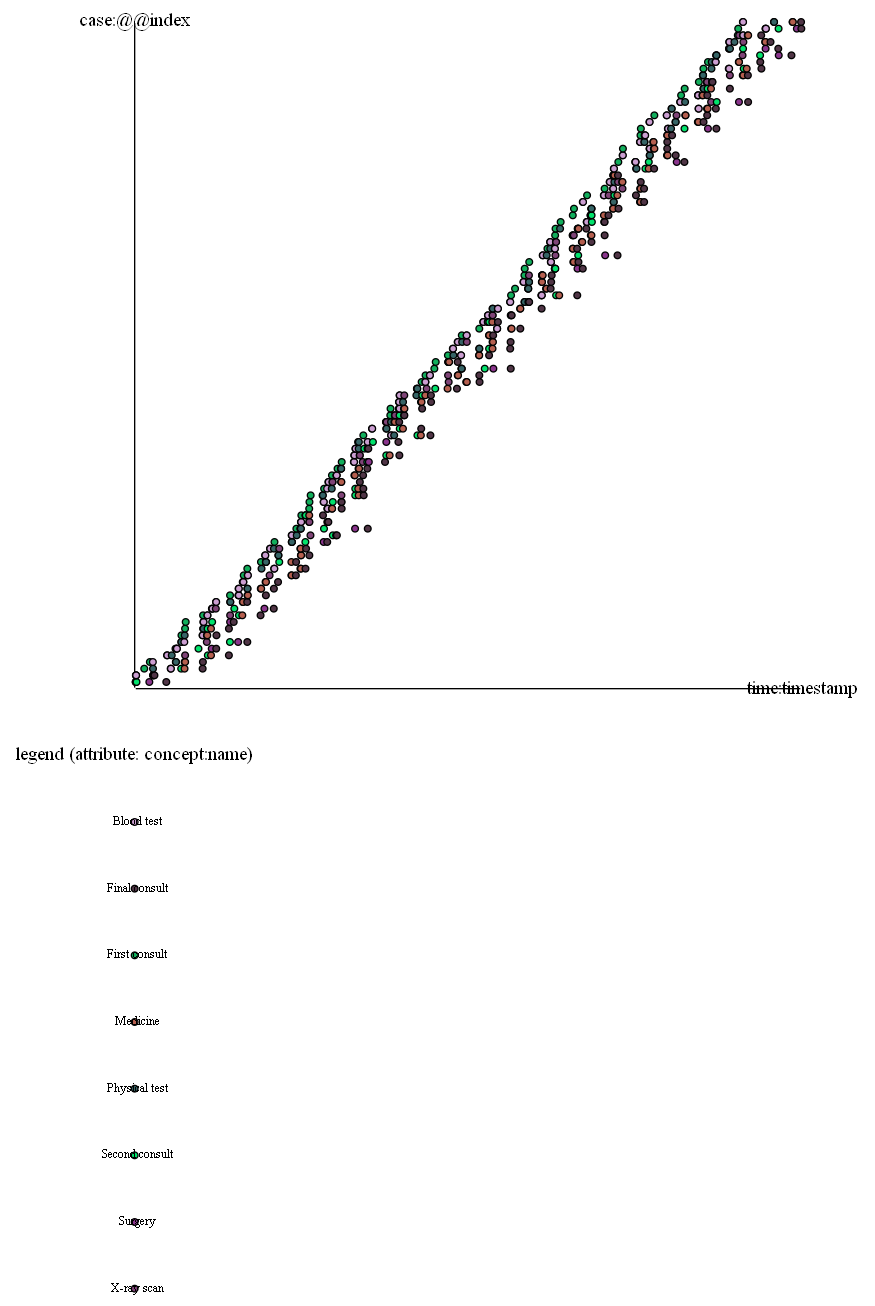

In [17]:
# dotted chart visualization
pm4py.view_dotted_chart(log)

In [18]:
# traces with activities carried out multiple times
rework = pm4py.get_rework_cases_per_activity(log)
rework

{}

### Footprint Analysis

In [19]:
# footprint analysis
fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)

In [20]:
fp_log

{'dfg': Counter({(' First consult', ' Blood test'): 40,
          (' Blood test', ' Physical test'): 35,
          (' Physical test', ' Second consult'): 36,
          (' Second consult', ' Surgery'): 20,
          (' Surgery', ' Final consult'): 20,
          (' First consult', ' Physical test'): 33,
          (' Physical test', ' Blood test'): 33,
          (' Blood test', ' X-ray scan'): 32,
          (' X-ray scan', ' Second consult'): 31,
          (' Second consult', ' Medicine'): 80,
          (' Medicine', ' Final consult'): 80,
          (' Physical test', ' X-ray scan'): 31,
          (' X-ray scan', ' Blood test'): 27,
          (' Blood test', ' Second consult'): 33,
          (' X-ray scan', ' Physical test'): 32,
          (' First consult', ' X-ray scan'): 27}),
 'sequence': {(' Blood test', ' Second consult'),
  (' First consult', ' Blood test'),
  (' First consult', ' Physical test'),
  (' First consult', ' X-ray scan'),
  (' Medicine', ' Final consult'),
  (' Physical

### Occurences of binary relations

In [21]:
fp_log['dfg']

Counter({(' First consult', ' Blood test'): 40,
         (' Blood test', ' Physical test'): 35,
         (' Physical test', ' Second consult'): 36,
         (' Second consult', ' Surgery'): 20,
         (' Surgery', ' Final consult'): 20,
         (' First consult', ' Physical test'): 33,
         (' Physical test', ' Blood test'): 33,
         (' Blood test', ' X-ray scan'): 32,
         (' X-ray scan', ' Second consult'): 31,
         (' Second consult', ' Medicine'): 80,
         (' Medicine', ' Final consult'): 80,
         (' Physical test', ' X-ray scan'): 31,
         (' X-ray scan', ' Blood test'): 27,
         (' Blood test', ' Second consult'): 33,
         (' X-ray scan', ' Physical test'): 32,
         (' First consult', ' X-ray scan'): 27})

### Causalities

In [22]:
fp_log['sequence']

{(' Blood test', ' Second consult'),
 (' First consult', ' Blood test'),
 (' First consult', ' Physical test'),
 (' First consult', ' X-ray scan'),
 (' Medicine', ' Final consult'),
 (' Physical test', ' Second consult'),
 (' Second consult', ' Medicine'),
 (' Second consult', ' Surgery'),
 (' Surgery', ' Final consult'),
 (' X-ray scan', ' Second consult')}

### Parallel

In [23]:
fp_log['parallel']

{(' Blood test', ' Physical test'),
 (' Blood test', ' X-ray scan'),
 (' Physical test', ' Blood test'),
 (' Physical test', ' X-ray scan'),
 (' X-ray scan', ' Blood test'),
 (' X-ray scan', ' Physical test')}

## Footprint table

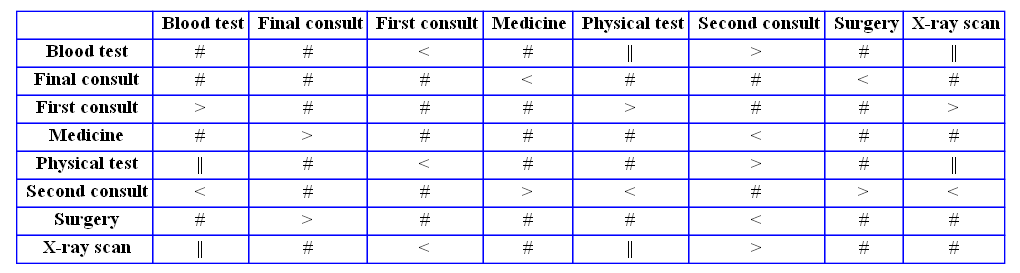

In [24]:
# caution: arrows mean "causality" here NOT "follows"
gviz = fp_visualizer.apply(fp_log)
fp_visualizer.view(gviz)

### Directly-follows graph

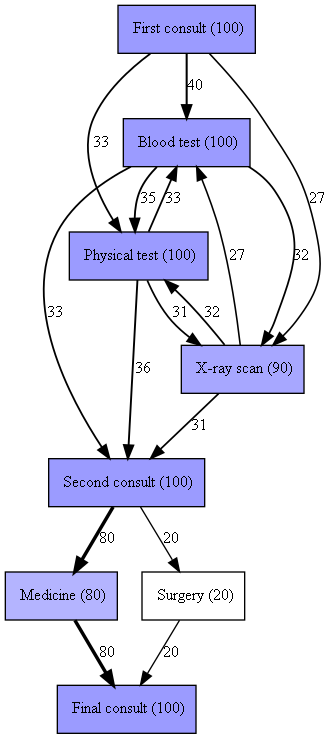

In [25]:
#Create graph from log (annotated with frequency)
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

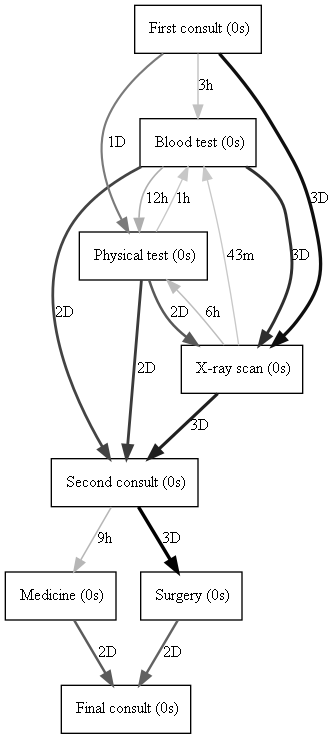

In [26]:
# creatig the graph from log (annotated with time)
dfg = dfg_discovery.apply(eventlog, variant=dfg_discovery.Variants.PERFORMANCE)

# viz
gviz = dfg_visualization.apply(dfg, log=eventlog, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)